In [1]:
from functools import partial

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar

from models.data import JSRTDataModule, CheXpertDataModule, CLEVRNDataset
from models.mae.mae import ViTAE
from models.encoders import CNNEncoder, ResNet34_8x8, get_resnet34_encoder, DinoViT_16, Dinov2ViT_14, DinoViT_8
from models.segmentation import ObjectSpecificSegmentation

from pytorch_lightning.loggers import WandbLogger
from pathlib import Path

from torch_uncertainty.metrics import AURC, AUSE
from torch_uncertainty.metrics.classification import CalibrationError
from monai.networks import one_hot
from torch_uncertainty.transforms.corruptions import (
    GaussianNoise,
    SpeckleNoise,
)

In [4]:
encoder = DinoViT_8()

oss = ObjectSpecificSegmentation.load_from_checkpoint('/vol/bitbucket/bc1623/project/semi_supervised_uncertainty/bash_scripts/runs/lightning_logs/chexray_final/chexray_final/42_ar_xtrakeys_lmlp/checkpoints/epoch=6469-step=45290.ckpt',
                                encoder=encoder, strict=False)

Using cache found in /homes/bc1623/.cache/torch/hub/facebookresearch_dino_main
/vol/bitbucket/bc1623/project/uncertainty_env/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['decoder.recons_block.self_attn_mask', 'decoder.recons_block.self_attn_layer_norm.weight', 'decoder.recons_block.self_attn_layer_norm.bias', 'decoder.recons_block.self_attn.proj_q.weight', 'decoder.recons_block.self_attn.proj_k.weight', 'decoder.recons_block.self_attn.proj_v.weight', 'decoder.recons_block.self_attn.proj_o.weight', 'decoder.recons_block.encoder_decoder_attn_layer_norm.weight', 'decoder.recons_block.encoder_decoder_attn_layer_norm.bias', 'decoder.recons_block.encoder_decoder_attn.proj_q.weight', 'decoder.recons_block.encoder_decoder_attn.proj_k.weight', 'decoder.recons_block.encoder_decoder_attn.proj_v.weight', 'decoder.recons_block.encoder_decoder_attn.proj_o.weight', 'decoder.recons_block.ffn_layer_norm.weight

In [5]:
def image_overlay(batch, image_num, pixel_entropy):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.imshow(batch['image'][image_num].squeeze().cpu(), cmap='gray')
    ax.imshow(pixel_entropy, cmap='plasma', alpha=0.5)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def ground_truth_overlay(batch, image_num, pixel_entropy):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.imshow(batch['labelmap'][image_num].squeeze().cpu(), cmap='gray')
    ax.imshow(pixel_entropy, cmap='plasma', alpha=0.5)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def uncertainty_metrics(oss, batch, trials=500, transform='GaussianNoise'):
    if transform == 'GaussianNoise':
        transform = GaussianNoise(5)
    elif transform == 'SpeckleNoise':
        transform = SpeckleNoise(5)
    else:
        transform = None

    aurc_metric = AURC()
    ece_metric = CalibrationError('multiclass', num_bins=20, num_classes=4, norm='l1')

    batch = {k: v.to('cuda') for k, v in batch.items()}
    for _ in range(trials):
        with torch.no_grad():
            if transform is not None:
                batch['image'] = transform(batch['image'])
            _, _, probs, preds, _, _, _, _ = oss.process_batch(batch, 1)
            targets = batch['labelmap'][:, 0].unsqueeze(1)     #one_hot(batch['ground_truth'], num_classes=4)
            # flatten probs and targets
            probs = probs.squeeze(2).permute(0, 2, 3, 1)
            probs = probs.reshape(-1, probs.shape[-1]).to('cpu')
            targets = targets.permute(0, 2, 3, 1)
            targets = targets.reshape(-1).to('cpu')  # Changed this line
            
            # flatten preds
            preds = preds.reshape(-1).to('cpu')  # Added this line
            
            # remove targets and probs where target is background class (0) and is correctly predicted
            # mask = ~((preds == 0) & (targets == 0))  
            # probs = probs[mask]
            # targets = targets[mask]
            
            # Convert targets to one-hot encoding
            targets = one_hot(targets.unsqueeze(1), num_classes=4).argmax(dim=1)
            
            aurc_metric.update(probs, targets)
            ece_metric.update(probs, targets)

    return ece_metric, aurc_metric

def get_samples(model, batch, trials=500, transform=None):
    if transform == 'GaussianNoise':
        transform = GaussianNoise(5)
    elif transform == 'SpeckleNoise':
        transform = SpeckleNoise(5)
    else:
        transform = None

    model.slot_attention.probabilistic_sample = True
    model.to('cuda')
    batch = {k: v.to('cuda') for k, v in batch.items()}
    list_entropy = []
    for _ in range(trials):
        with torch.no_grad():
            if transform is not None:
                batch['image'] = transform(batch['image'])

            _, _, _, preds, _, _, _, _ = model.process_batch(batch, 1)

            list_entropy.append(preds)

    all_preds = torch.stack(list_entropy, dim=1)

    return all_preds.float()

In [6]:
data = JSRTDataModule(data_dir='./data/JSRT/', batch_size=32, augmentation=True, random_seed=42)
data_chex = CheXpertDataModule(data_dir='/vol/biodata/data/chest_xray/CheXpert-v1.0/preproc_224x224/', batch_size=8, cache=False, augmentation=False)

True


Loading Data: 100%|██████████| 25/25 [00:00<00:00, 16343.14it/s]


Loading Data: 100%|██████████| 25424/25424 [00:00<00:00, 1662058.09it/s]


In [ ]:
# from pytorch_lightning.loggers import WandbLogger
# wandb_logger = WandbLogger(save_dir='./runs/lightning_logs/obj_centric_chest_seg/', project='probabilistic_seg',
#                            name='dino_unsup_3', id='dino_unsup_3', offline=True)
# output_dir = Path(f"obj_centric_chest_seg/run_{wandb_logger.experiment.id}")  # type: ignore
# print("Saving to" + str(output_dir.absolute()))
# oss.include_seg_loss = True
# trainer = Trainer(
#     max_epochs=2500,
#     precision='16-mixed',
#     accelerator='auto',
#     devices=[0],
#     #strategy='ddp_notebook',
#     # log_every_n_steps=250,
#     # val_check_interval=0.25,
#     check_val_every_n_epoch=25,
#     # #save_top_k=1,
#     logger=wandb_logger,
#     # callbacks=[ModelCheckpoint(monitor="val_loss", mode='min'), TQDMProgressBar(refresh_rate=100)],
# )
# torch.set_float32_matmul_precision('medium')

# trainer.fit(model=oss, datamodule=data)

# trainer.validate(model=oss, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

# trainer.test(model=oss, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

Text(0.5, 1.0, 'Variance Map')

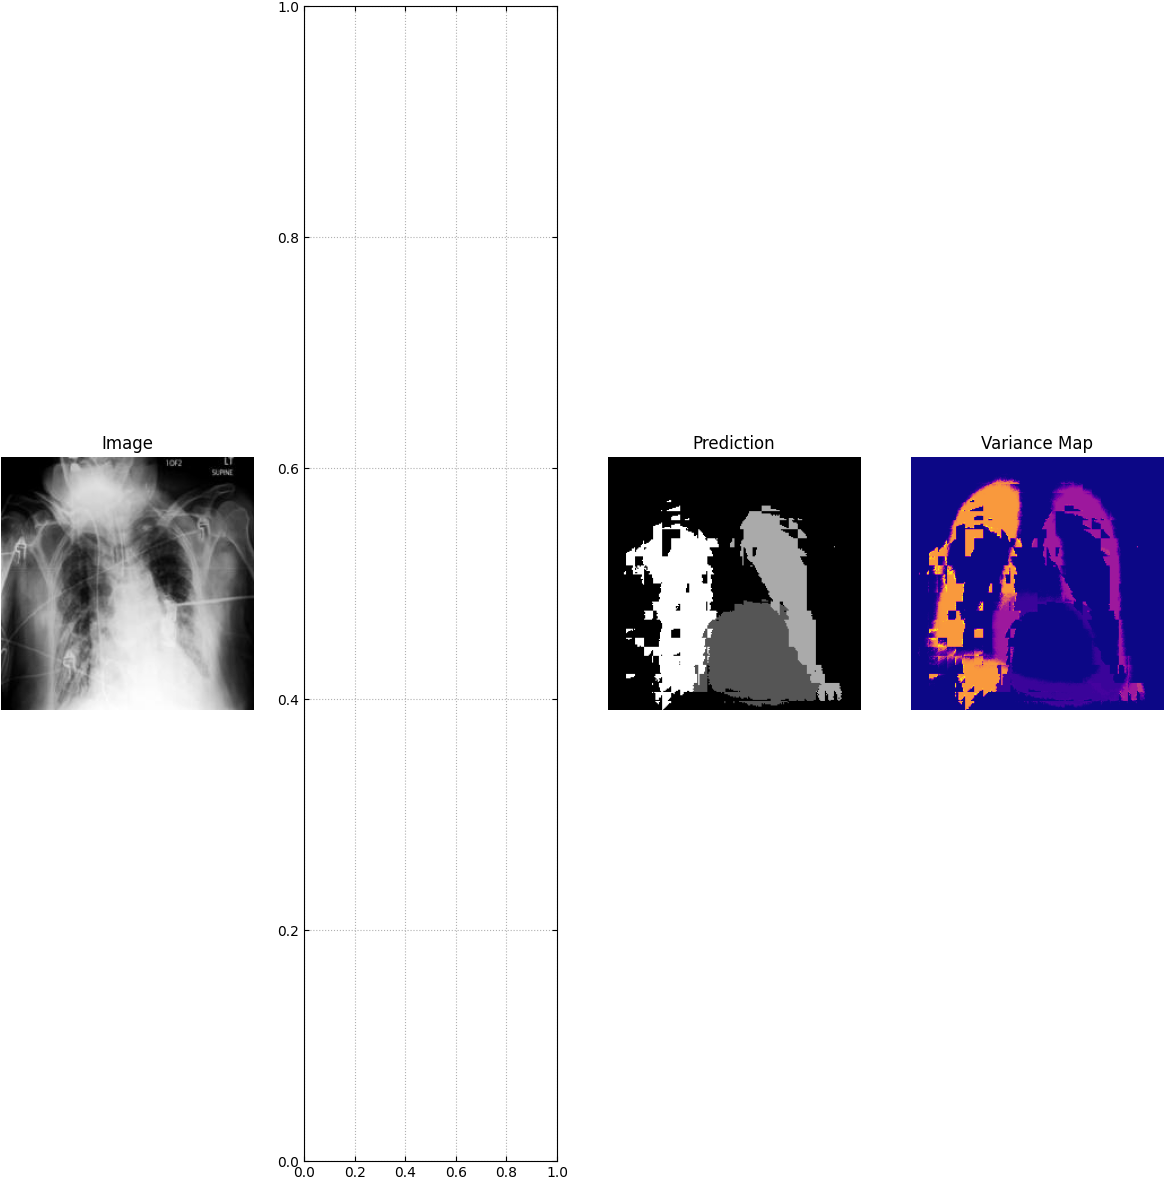

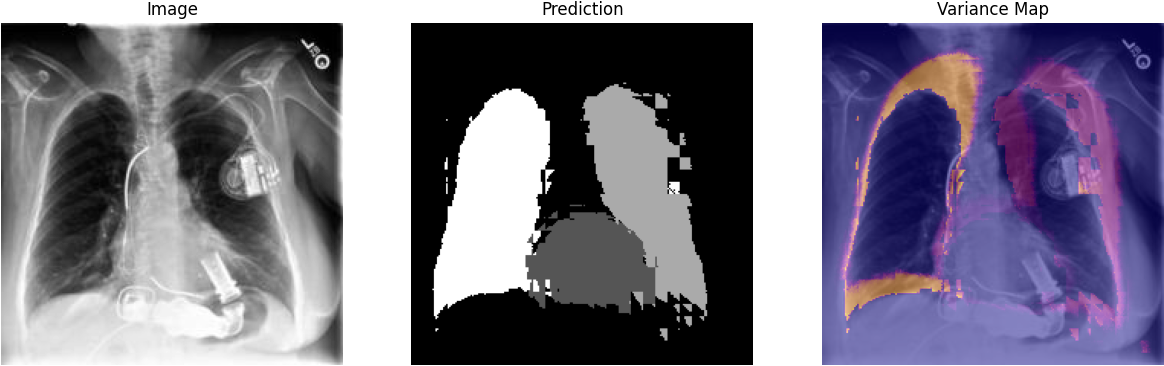

In [8]:
image_num = 0
oss.num_iterations = 10
batch = next(iter(data_chex.test_dataloader()))
cuda_device = torch.device('cuda:0')
import numpy as np
oss.include_seg_loss = False
oss.slot_attention.probabilistic_sample = False
oss.to(cuda_device)

batch['image'] = batch['image']
# move to gpu
batch = {k: v.to(cuda_device) for k, v in batch.items()}

with torch.no_grad():
    loss, dsc, probs, preds, _, _, _, attn = oss.process_batch(batch, 1)
image = batch['image'][image_num].squeeze().cpu()
# labelmap = batch['labelmap'][image_num].squeeze().cpu()
predmap = preds[image_num].squeeze().cpu()

f, ax = plt.subplots(1, 4, figsize=(15, 15))

ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('Image')

# ax[1].imshow(labelmap, cmap=matplotlib.cm.gray)
# ax[1].axis('off')
# ax[1].set_title('labelmap')

ax[2].imshow(predmap, cmap=matplotlib.cm.gray)
ax[2].axis('off')
ax[2].set_title('Prediction')

pixel_entropy = torch.var(get_samples(oss, batch, trials=500, transform=None), dim=1).squeeze().cpu()
ax[3].imshow(pixel_entropy[image_num], cmap='plasma')
ax[3].axis('off')
ax[3].set_title('Variance Map')

image_num += 1
image = batch['image'][image_num].squeeze().cpu()
# labelmap = batch['labelmap'][image_num].squeeze().cpu()
predmap = preds[image_num].squeeze().cpu()

f, ax = plt.subplots(1, 3, figsize=(15, 15))

ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('Image')

# ax[1].imshow(labelmap, cmap=matplotlib.cm.gray)
# ax[1].axis('off')
# ax[1].set_title('labelmap')

ax[1].imshow(predmap, cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('Prediction')

# pixel_entropy = torch.var(get_samples(oss, batch, trials=500, transform=None), dim=1).squeeze().cpu()
ax[2].imshow(image, cmap=matplotlib.cm.gray)
ax[2].imshow(pixel_entropy[image_num], cmap='plasma', alpha=0.5)
ax[2].axis('off')
ax[2].set_title('Variance Map')

Text(0.5, 1.0, 'Variance Map')

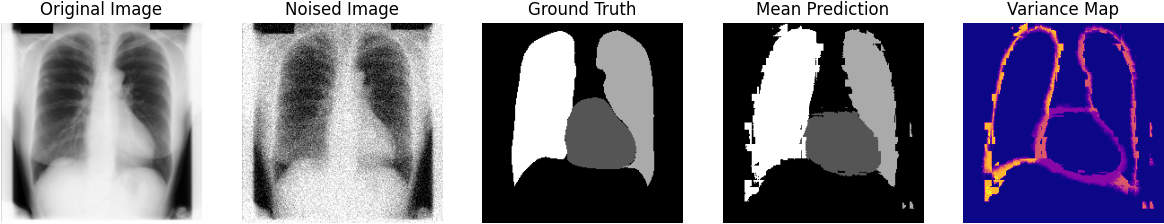

: 

In [9]:
image_num = 0
# data = SynthCardDataModule(batch_size=25, rate_maps=1.0, augmentation=False, cache=True, random_seed=42)
batch = next(iter(data.test_dataloader()))
cuda_device = torch.device('cuda:0')
batch = {k: v.to(cuda_device) for k, v in batch.items()}
oss.to(cuda_device)
oss.slot_attention.probabilistic_sample = False
oss.num_iterations = 10
noised_batch = batch.copy()
transform = GaussianNoise(5)
noised_batch['image'] = transform(noised_batch['image'])
with torch.no_grad():
    loss, dsc, probs, preds, _, _, _, attn = oss.process_batch(noised_batch, 1)
image = batch['image'][image_num].squeeze().cpu()
noised_image = noised_batch['image'][image_num].squeeze().cpu()
labelmap = batch['labelmap'][image_num].squeeze().cpu()
predmap = preds[image_num].squeeze().cpu()

f, ax = plt.subplots(1, 5, figsize=(15, 15))

ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original Image')

ax[1].imshow(noised_image, cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('Noised Image')

ax[2].imshow(labelmap, cmap=matplotlib.cm.gray)
ax[2].axis('off')
ax[2].set_title('Ground Truth')

ax[3].imshow(predmap, cmap=matplotlib.cm.gray)
ax[3].axis('off')
ax[3].set_title('Mean Prediction')

pixel_entropy = torch.std(get_samples(oss, noised_batch), dim=1)[image_num].squeeze().cpu()
ax[4].imshow(pixel_entropy, cmap='plasma')
ax[4].axis('off')
ax[4].set_title('Variance Map')

In [6]:
cuda_device = 'cuda:0'
oss.probabilistic_sample = True
oss.include_seg_loss = False

(-0.5, 223.5, 223.5, -0.5)

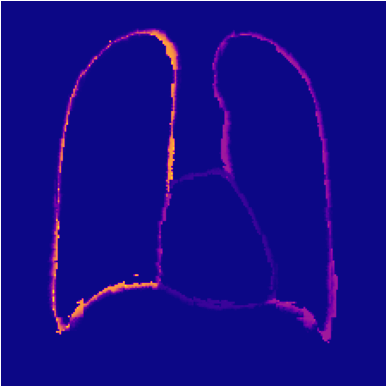

In [27]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.imshow(pixel_entropy[2], cmap='plasma')
ax.axis('off')

TypeError: Invalid shape (224,) for image data

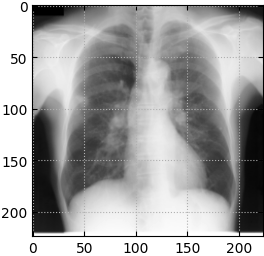

In [34]:
image_overlay(batch, 1, pixel_entropy[1])

In [36]:
batch = next(iter(data.test_dataloader()))
ece_metric, aurc_metric = uncertainty_metrics(oss, batch, trials=500, transform='GaussianNoise')

In [37]:
ece_metric.compute()

tensor(0.0446)

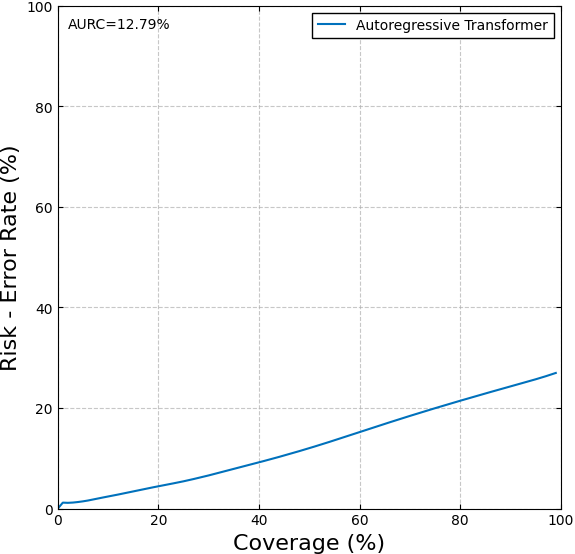

: 

In [38]:
figure, ax = aurc_metric.plot(name='Autoregressive Transformer')

In [31]:
# show ax with x axis up to 25%
ax.imshow(figure)

TypeError: Image data of dtype object cannot be converted to float

In [ ]:
# calculate dice score on entire test set
data = JSRTDataModule(data_dir='./data/JSRT/', batch_size=200, augmentation=False, random_seed=42)

In [ ]:
from torchmetrics.functional import dice
batch = next(iter(data.test_dataloader()))
batch = {k: v.to(cuda_device) for k, v in batch.items()}
gt = batch['labelmap'].squeeze().to('cuda')
oss.to('cuda')
with torch.no_grad():
    loss, dsc, probs, preds, _, _, _, attn = oss.process_batch(batch, 1)
dsc = dice(preds, gt, average='macro', num_classes=4, ignore_index=0)
print(dsc)